In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re
import pickle
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic
from tabulate import tabulate

sys.path.insert(1, '../')
from Prepare_Events_Functions import *
from Plot_events_functions import *

In [18]:
def create_normalised_event(rainfall):
    # Check if the input array is None or empty
    if rainfall is None or len(rainfall) == 0:
        # print("Input array is None or empty. Cannot normalize.")
        return None

    # Check if the maximum value is zero to avoid division by zero
    if np.max(rainfall) == 0:
        print("Maximum rainfall is zero. Cannot normalize.")
        return rainfall  # Return the input as-is, or handle appropriately

    # Normalize rainfall from 0 to 1 using the maximum value
    normalized_rainfall = rainfall / np.max(rainfall)

    # Debug prints to check the input and output
    return normalized_rainfall

def create_cumulative_event(rainfall):
    
    # Calculate cumulative rainfall
    cumulative_rainfall = np.cumsum(rainfall)
    
    return cumulative_rainfall

def interpolate_rainfall(rainfall, bin_number):
    if rainfall is None or len(rainfall) < 2:
        return None

    # Define target points for bin_number bins
    target_points = np.linspace(0, 1, bin_number)
    
    # Create interpolation function based on existing data points
    rainfall_times = np.array(range(0, len(rainfall)))

    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    interpolation_func = interp1d(normalized_time, rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values


def create_incremental_event(cumulative_rainfall):
    if cumulative_rainfall is None :
        return None
    
    raw_rainfall = np.diff(cumulative_rainfall, prepend=0)
    raw_rainfall[0] = cumulative_rainfall[0]
    return raw_rainfall

In [19]:
def find_part_with_most_rain(array, n, plot=False, ax=False):
    if array is None:
        return None
    else:

        # Compute differences
        # Split the array into 5 equal parts
        splits = np.array_split(array, n)

        max_array_rainfall = 0
        max_array_num = None

        total_precipitations = []  # To store total precipitation for each split
        split_ranges = []  # To store start and end indices for each split

        # Calculate total precipitation for each split
        split_start = 0
        for split in splits:
            total_precipitation = split.sum()
            total_precipitations.append(total_precipitation)
            split_end = split_start + len(split)
            split_ranges.append((split_start, split_end))
            if total_precipitation > max_array_rainfall:
                max_array_num = len(total_precipitations)
                max_array_rainfall = total_precipitation
            split_start = split_end

        colors = ['lightblue'] * n  # Default color for all splits
        highlight_color = 'yellow'  # Color for the split with the most rainfall

        if plot:
            # Plot the array
            ax.plot(range(1, len(array) + 1), array, label='Precipitation', marker='o')

            # Add vertical lines and shading for each split segment
            for i, (start_index, end_index) in enumerate(split_ranges):
                color = highlight_color if (i + 1) == max_array_num else colors[i]

                # Add vertical lines at the start and end of each split
                ax.axvline(x=start_index + 1, color=color, linestyle='--', label=f'Split {i+1} Start' if i == 0 or (i + 1) == max_array_num else "")
                ax.axvline(x=end_index, color=color, linestyle='--', label=f'Split {i+1} End' if i == 0 or (i + 1) == max_array_num else "")

                # Shade the region for the split
                ax.fill_between(range(start_index + 1, end_index + 1), array[start_index:end_index], color=color, alpha=0.3)

                # Add the total precipitation value behind the shading
                ax.text((start_index + end_index) / 2+0.5, max(array) * 0.05,  # Adjust y-position if needed
                        f'{total_precipitations[i]:.2f}',
                        ha='center', va='center', fontsize=10, color='black', weight='bold', zorder=1)

            ax.set_title(f'Precipitation Values with Splits Marked. Max at {max_array_num}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Precipitation')

    return max_array_num

In [27]:
def create_single_variable_mosaic_plot_pctlabels(ax, data, rainfall_variable, split_variable, order, color_mapping, title, filter_events=True):
    if filter_events == True:
         data= data[data[rainfall_variable].notnull()]
    # Count the occurrences and reshape for mosaic plot
    count_data = data[split_variable].value_counts().reindex(order, fill_value=0)
    
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    fig, rects = mosaic(mosaic_data, title='', properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.2f}%'
        #print(counter)
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in [0,6,12,18,24]:
                text.set_text(label)
                text.set_fontsize(10)
                text.set_color('black')
#                 text.set_weight('bold')
            counter=counter+1
            
        #print(f'Key: {key}, count {count} Percentage: {percentage:.2f}%, Label: {label}, x1: {x1}, x2: {x2}, y1: {y1}, y2: {y2}')

    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')      

In [4]:
color_mapping = {
    'F2': (0.0, 0.0, 1.0, 0.6),    # darkblue with 0.6 alpha
    'F1': (0.0, 0.6902, 1.0, 0.6), # deepskyblue with 0.6 alpha
    'C': (0.5, 0.5, 0.5, 0.6),     # grey with 0.6 alpha
    'B1': (0.8039, 0.0, 0.0, 0.6), # indianred with 0.6 alpha
    'B2': (0.5451, 0.0, 0.0, 0.6)}  # darkred with 0.6 alpha

color_mapping_seasons = {
    'Summer': (1.0, 0.6471, 0.0, 0.6), # orange with 0.6 alpha
    'Winter': (0.0, 0.0, 1.0, 0.6)}     # blue with 0.6 alpha}

quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
n= 5
quintile_cats_season = ['Summer', 'Winter']    

# Read in data
For events with n data points which is a multiple of 5

In [6]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/bc005/profiles_df.pkl", 'rb') as f:
    bc005 = pickle.load(f)    
bc005 = add_duration_cats_based_on_data(bc005)
bc005 = add_duration_cats_predetermined(bc005)

In [7]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/bb198/profiles_df.pkl", 'rb') as f:
    bb198 = pickle.load(f)  
bb198 = add_duration_cats_based_on_data(bb198)
bb198 = add_duration_cats_predetermined(bb198)    

In [11]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/bb189/profiles_df.pkl", 'rb') as f:
    bb189 = pickle.load(f)  
bb189 = add_duration_cats_based_on_data(bb189)
bb189 = add_duration_cats_predetermined(bb189)    

In [12]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_30mins/WholeYear/NIMROD_2.2km_filtered_100_profiles_df.pkl", 'rb') as f:
    nimrod = pickle.load(f)  
nimrod = add_duration_cats_based_on_data(nimrod)
nimrod = add_duration_cats_predetermined(nimrod)    

## Add new columns

In [20]:
nimrod['normalized_rainfall_new'] = nimrod['normalized_rainfall'].apply(create_normalised_event)
nimrod['cumulative_normalised_rainfall'] =nimrod['normalized_rainfall_new'].apply(create_cumulative_event)
nimrod['interpolated15_cumulative_normalised_rainfall'] = nimrod['cumulative_normalised_rainfall'].apply(lambda x: interpolate_rainfall(x, 15))
nimrod['interpolated12_cumulative_normalised_rainfall'] = nimrod['cumulative_normalised_rainfall'].apply(lambda x: interpolate_rainfall(x, 12))
nimrod['interpolated15_incremental_normalised_rainfall'] = nimrod['interpolated15_cumulative_normalised_rainfall'].apply(create_incremental_event)
nimrod['interpolated12_incremental_normalised_rainfall'] = nimrod['interpolated12_cumulative_normalised_rainfall'].apply(create_incremental_event)


nimrod['max_quintile_profile_12_new'] = nimrod['interpolated12_incremental_normalised_rainfall'].apply(lambda x: find_part_with_most_rain(x, 5))
nimrod['max_quintile_profile_15_new'] = nimrod['interpolated15_incremental_normalised_rainfall'].apply(lambda x: find_part_with_most_rain(x, 5))
nimrod['max_quintile_normalised_rain_new'] = nimrod['normalized_rainfall_new'].apply(lambda x: find_part_with_most_rain(x, 5))
nimrod['max_quintile_raw_rain_new'] = nimrod['precip'].apply(lambda x: find_part_with_most_rain(x, 5))



In [21]:
bc005['normalized_rainfall_new'] = bc005['normalized_rainfall'].apply(create_normalised_event)
bc005['cumulative_normalised_rainfall'] =bc005['normalized_rainfall_new'].apply(create_cumulative_event)
bc005['interpolated15_cumulative_normalised_rainfall'] = bc005['cumulative_normalised_rainfall'].apply(lambda x: interpolate_rainfall(x, 15))
bc005['interpolated12_cumulative_normalised_rainfall'] = bc005['cumulative_normalised_rainfall'].apply(lambda x: interpolate_rainfall(x, 12))
bc005['interpolated15_incremental_normalised_rainfall'] = bc005['interpolated15_cumulative_normalised_rainfall'].apply(create_incremental_event)
bc005['interpolated12_incremental_normalised_rainfall'] = bc005['interpolated12_cumulative_normalised_rainfall'].apply(create_incremental_event)


bc005['max_quintile_profile_12_new'] = bc005['interpolated12_incremental_normalised_rainfall'].apply(lambda x: find_part_with_most_rain(x, 5))
bc005['max_quintile_profile_15_new'] = bc005['interpolated15_incremental_normalised_rainfall'].apply(lambda x: find_part_with_most_rain(x, 5))
bc005['max_quintile_normalised_rain_new'] = bc005['normalized_rainfall_new'].apply(lambda x: find_part_with_most_rain(x, 5))
bc005['max_quintile_raw_rain_new'] = bc005['precip'].apply(lambda x: find_part_with_most_rain(x, 5))



In [22]:
bb198['normalized_rainfall_new'] = bb198['normalized_rainfall'].apply(create_normalised_event)
bb198['cumulative_normalised_rainfall'] =bb198['normalized_rainfall_new'].apply(create_cumulative_event)
bb198['interpolated15_cumulative_normalised_rainfall'] = bb198['cumulative_normalised_rainfall'].apply(lambda x: interpolate_rainfall(x, 15))
bb198['interpolated12_cumulative_normalised_rainfall'] = bb198['cumulative_normalised_rainfall'].apply(lambda x: interpolate_rainfall(x, 12))
bb198['interpolated15_incremental_normalised_rainfall'] = bb198['interpolated15_cumulative_normalised_rainfall'].apply(create_incremental_event)
bb198['interpolated12_incremental_normalised_rainfall'] = bb198['interpolated12_cumulative_normalised_rainfall'].apply(create_incremental_event)


bb198['max_quintile_profile_12_new'] = bb198['interpolated12_incremental_normalised_rainfall'].apply(lambda x: find_part_with_most_rain(x, 5))
bb198['max_quintile_profile_15_new'] = bb198['interpolated15_incremental_normalised_rainfall'].apply(lambda x: find_part_with_most_rain(x, 5))
bb198['max_quintile_normalised_rain_new'] = bb198['normalized_rainfall_new'].apply(lambda x: find_part_with_most_rain(x, 5))
bb198['max_quintile_raw_rain_new'] = bb198['precip'].apply(lambda x: find_part_with_most_rain(x, 5))

In [23]:
bb189['normalized_rainfall_new'] = bb189['normalized_rainfall'].apply(create_normalised_event)
bb189['cumulative_normalised_rainfall'] =bb189['normalized_rainfall_new'].apply(create_cumulative_event)
bb189['interpolated15_cumulative_normalised_rainfall'] = bb189['cumulative_normalised_rainfall'].apply(lambda x: interpolate_rainfall(x, 15))
bb189['interpolated12_cumulative_normalised_rainfall'] = bb189['cumulative_normalised_rainfall'].apply(lambda x: interpolate_rainfall(x, 12))
bb189['interpolated15_incremental_normalised_rainfall'] = bb189['interpolated15_cumulative_normalised_rainfall'].apply(create_incremental_event)
bb189['interpolated12_incremental_normalised_rainfall'] = bb189['interpolated12_cumulative_normalised_rainfall'].apply(create_incremental_event)


bb189['max_quintile_profile_12_new'] = bb189['interpolated12_incremental_normalised_rainfall'].apply(lambda x: find_part_with_most_rain(x, 5))
bb189['max_quintile_profile_15_new'] = bb189['interpolated15_incremental_normalised_rainfall'].apply(lambda x: find_part_with_most_rain(x, 5))
bb189['max_quintile_normalised_rain_new'] = bb189['normalized_rainfall_new'].apply(lambda x: find_part_with_most_rain(x, 5))
bb189['max_quintile_raw_rain_new'] = bb189['precip'].apply(lambda x: find_part_with_most_rain(x, 5))

In [24]:
for df in [nimrod, bc005, bb198, bb189]:

    df['Loading_profile12_new'] = df['max_quintile_profile_12_new'].map(quintile_mapping)
    df['Loading_profile15_new'] = df['max_quintile_profile_15_new'].map(quintile_mapping)
    df['Loading_profile_normalised_rain_new'] = df['max_quintile_normalised_rain_new'].map(quintile_mapping)
    df['Loading_profile_raw_rain_new'] = df['max_quintile_raw_rain_new'].map(quintile_mapping)


## Create trimmed versions of dataframes

In [28]:
nimrod_divisibleby5 = nimrod[nimrod['precip'].apply(is_multiple_of_5)]
nimrod_shortdurations = nimrod[nimrod["duration"]<6]
nimrod_longdurations = nimrod[nimrod["duration"]>=6]
nimrod_shortdurations_divisibleby5 = nimrod_shortdurations[nimrod_shortdurations['precip'].apply(is_multiple_of_5)]
nimrod_longdurations_divisibleby5 = nimrod_longdurations[nimrod_longdurations['precip'].apply(is_multiple_of_5)]

In [29]:
bc005_divisibleby5 = bc005[bc005['precip'].apply(is_multiple_of_5)]
bc005_shortdurations = bc005[bc005["duration"]<6]
bc005_longdurations = bc005[bc005["duration"]>=6]
bc005_shortdurations_divisibleby5 = bc005_shortdurations[bc005_shortdurations['precip'].apply(is_multiple_of_5)]
bc005_longdurations_divisibleby5 = bc005_longdurations[bc005_longdurations['precip'].apply(is_multiple_of_5)]

In [30]:
bb198_divisibleby5 = bb198[bb198['precip'].apply(is_multiple_of_5)]
bb198_shortdurations = bb198[bb198["duration"]<6]
bb198_longdurations = bb198[bb198["duration"]>=6]
bb198_shortdurations_divisibleby5 = bb198_shortdurations[bb198_shortdurations['precip'].apply(is_multiple_of_5)]
bb198_longdurations_divisibleby5 = bb198_longdurations[bb198_longdurations['precip'].apply(is_multiple_of_5)]

In [31]:
bb189_divisibleby5 = bb189[bb189['precip'].apply(is_multiple_of_5)]
bb189_shortdurations = bb189[bb189["duration"]<6]
bb189_longdurations = bb189[bb189["duration"]>=6]
bb189_shortdurations_divisibleby5 = bb189_shortdurations[bb189_shortdurations['precip'].apply(is_multiple_of_5)]
bb189_longdurations_divisibleby5 = bb189_longdurations[bb189_longdurations['precip'].apply(is_multiple_of_5)]

# Check the number of events we have for each dataset
The number of files for UKCP18 present and future is similar. The difference between the two is likely because of differences in deletion of duplicate events.  

The number of files for NIMROD is less:
- This is likely because NIMROD includes 15 years of data (2006-2020) compared to 19 years for the UKCP18 datasets (2001-2019 and 2061-2079). 
- If we divide the number of events by the number of years over which they are calculated the result is now similar.

In [160]:
print(f"There are {len(ukcp18_present)} UKCP18 present")
# print(len(ukcp18_future_new[ukcp18_future_new['Profile'].notnull()]))
print(f"There are {len(ukcp18_future)} UKCP18 future")
print(f"There are {len(nimrod)} NIMROD files")

There are 119388 UKCP18 present
There are 107246 UKCP18 future
There are 88896 NIMROD files


In [79]:
print(f"There are {len(ukcp18_present)} UKCP18 present")
# print(len(ukcp18_future_new[ukcp18_future_new['Profile'].notnull()]))
print(f"There are {len(ukcp18_future)} UKCP18 future")
print(f"There are {len(nimrod)} NIMROD files")

There are 125253 UKCP18 present
There are 112275 UKCP18 future
There are 88952 NIMROD files


In [155]:
print(int(len(ukcp18_present)/19))
print(int(len(ukcp18_future)/19))
print(int(len(nimrod)/15))

6283
5644
5926


## Is it possible to select just events from certain years - would this make results more similar?
Makes no difference

## NIMROD and UKCP18 present seasonal split in different years

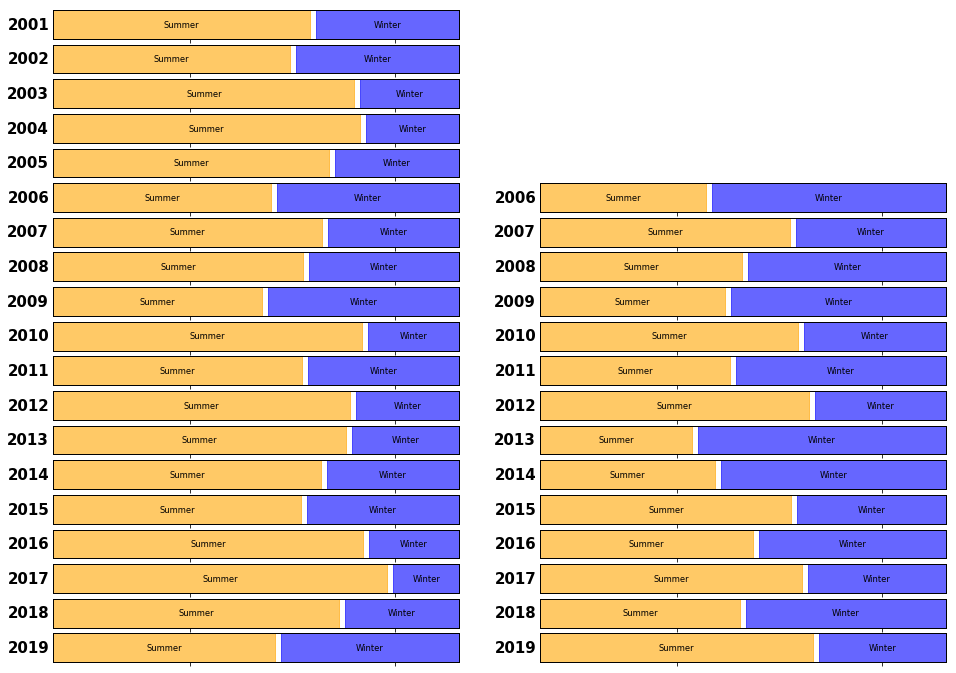

In [89]:
fig, axs = plt.subplots(nrows=19, ncols =2, figsize=(16, 12), sharex=True)
for number, year in enumerate(range(2001,2020)):
    trimmed = bc005[bc005['Year'] == year]
    create_single_variable_mosaic_plot(axs[number, 0], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False)
for number, year in enumerate(range(2001,2020)):
    if year in range(2001,2006):
        axs[number,1].remove()
    else:
        trimmed = nimrod[nimrod['Year'] == year]
        create_single_variable_mosaic_plot(axs[number,1], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False) 


# UKCP18 present and future

In [50]:
bb189

,gauge_num,season,precip,Volume,Year,duration,normalized_rainfall,normalized_interpolated_rainfall_12,normalized_interpolated_rainfall_15,max_quintile_profile_12,...,interpolated15_incremental_normalised_rainfall,interpolated12_incremental_normalised_rainfall,max_quintile_profile_12_new,max_quintile_profile_15_new,max_quintile_normalised_rain_new,max_quintile_raw_rain_new,Loading_profile12_new,Loading_profile15_new,Loading_profile_normalised_rain_new,Loading_profile_raw_rain_new
0,1223,Summer,"[0.015121305, 6.9091535, 13.659597]",20.583872,Unnamed: 0 precipitation (mm/hr) ...,1.5,"[0.0007346190815435852, 0.33639321458065213, 1.0]","[0.0007346190815435852, 0.056677718331395004, ...","[0.0007346190815435852, 0.04548909848142472, 0...",4,...,"[0.0007346190815435852, 0.04805617351152173, 0...","[0.0007346190815435852, 0.06116240265102766, 0...",4.0,5.0,3.0,3,B1,B2,C,C
1,1063,Summer,"[1.2730451, 15.500673, 6.310904]",23.084622,Unnamed: 0 precipitation (mm/hr) ...,1.5,"[0.055146889322481046, 0.7266186999872959, 1.0]","[0.055146889322481046, 0.16705885776661686, 0....","[0.055146889322481046, 0.1446764640777897, 0.2...",1,...,"[0.055146889322481046, 0.10380267142675656, 0....","[0.055146889322481046, 0.13211249090678107, 0....",2.0,5.0,3.0,2,F1,B2,C,F1
2,69,Summer,"[4.7911296, 36.051163, 9.3336525]",50.175945,Unnamed: 0 precipitation (mm/hr) ...,1.5,"[0.09548658406834871, 0.8139815307634335, 1.0]","[0.09548658406834871, 0.21523574185086283, 0.3...","[0.09548658406834871, 0.19128591029436, 0.2870...",2,...,"[0.09548658406834871, 0.11628307582334764, 0.1...","[0.09548658406834871, 0.14799664195698792, 0.1...",2.0,4.0,3.0,2,F1,B1,C,F1
3,1237,Summer,"[29.876352, 35.76731, 5.693981]",71.337643,Unnamed: 0 precipitation (mm/hr) ...,1.5,"[0.41880206218756066, 0.9201826586841397, 1.0]","[0.41880206218756066, 0.5023654949369905, 0.58...","[0.41880206218756066, 0.48565280838710456, 0.5...",1,...,"[0.41880206218756066, 0.1314546655263057, 0.13...","[0.41880206218756066, 0.16730593794257087, 0.1...",1.0,1.0,3.0,2,F2,F2,C,F1
4,593,Summer,"[19.093233, 23.258852, 2.7193675]",45.071452,Unnamed: 0 precipitation (mm/hr) ...,1.5,"[0.423621426445043, 0.9396654123804864, 1.0]","[0.423621426445043, 0.5096287574342836, 0.5956...","[0.423621426445043, 0.49242729123643547, 0.561...",1,...,"[0.423621426445043, 0.13423791605435526, 0.134...","[0.423621426445043, 0.17084825679645205, 0.170...",1.0,1.0,3.0,2,F2,F2,C,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176970,1290,None,"[5.3574953, 48.771]",54.128495,Unnamed: 0 precipitation (mm/hr) ...,NaN,None,None,None,None,...,None,None,NaN,NaN,NaN,2,NaN,NaN,NaN,F1
176971,1291,None,"[1.7327291, 2.459835, 1.5326631, 0.41038322, 0...",35.338299,Unnamed: 0 precipitation (mm/hr) ...,NaN,None,None,None,None,...,None,None,NaN,NaN,NaN,5,NaN,NaN,NaN,B2
176972,1292,None,"[24.780766, 0.7029539]",25.483720,Unnamed: 0 precipitation (mm/hr) ...,NaN,None,None,None,None,...,None,None,NaN,NaN,NaN,1,NaN,NaN,NaN,F2
176973,1292,None,"[0.13208765, 34.524723]",34.656811,Unnamed: 0 precipitation (mm/hr) ...,NaN,None,None,None,None,...,None,None,NaN,NaN,NaN,2,NaN,NaN,NaN,F1


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

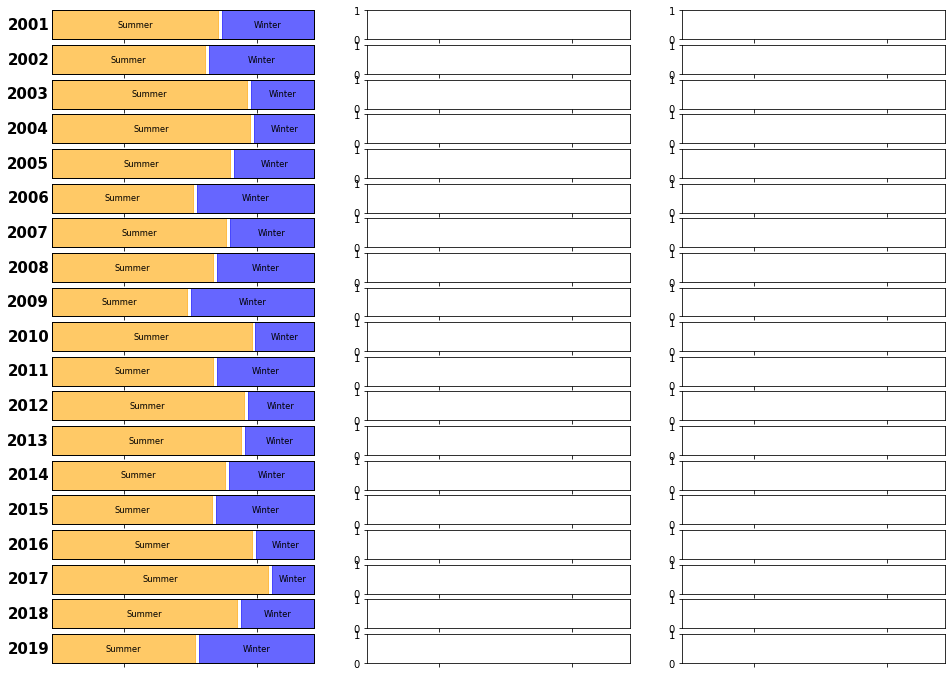

In [49]:
fig, axs = plt.subplots(nrows=19, ncols =3, figsize=(16, 12), sharex=True)
for number, year in enumerate(range(2001,2020)):
    trimmed = bc005[bc005['Year'] == year]
    create_single_variable_mosaic_plot(axs[number, 0], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False)
for number, year in enumerate(range(2061,2080)):
    trimmed = bb189[bb189['Year'] == year]
    create_single_variable_mosaic_plot(axs[number, 1], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False)    
for number, year in enumerate(range(2061,2080)):
    trimmed = ukcp18_future[ukcp18_future['Year'] == year]
    create_single_variable_mosaic_plot(axs[number,2], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False) 

# Seasonality of AMAX events
There are more events in summer in UKCP18 than in NIMROD.  
There are more events in summer in UKCP18 present than UKCP18 future.

This includes events that are too short to be used in the profiling.

The only reason I can think for this, is missing data in NIMROD. I can't think of anyway to check this.

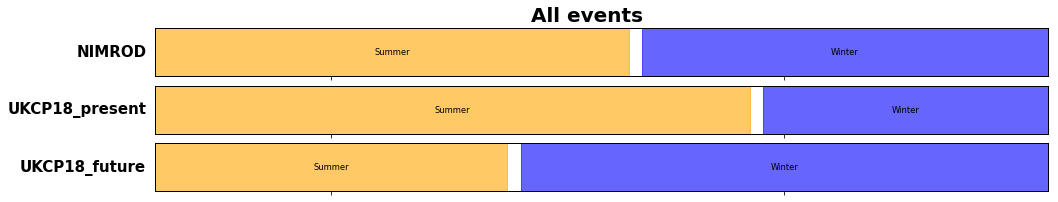

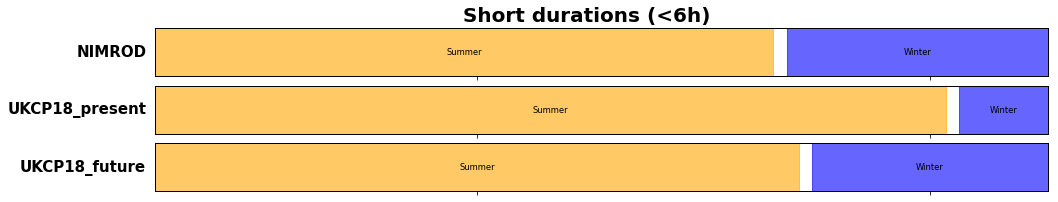

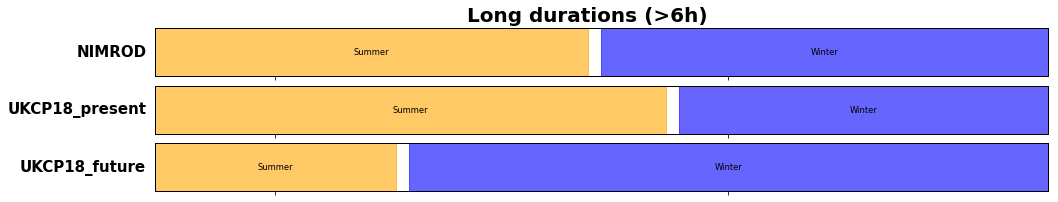

In [90]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 3), sharex=True)  # Adjusted figure size
# Plot with custom labels
create_single_variable_mosaic_plot(axs[0], nimrod, 'season', quintile_cats_season, color_mapping_seasons, 'NIMROD', False)
create_single_variable_mosaic_plot(axs[1], bc005, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_present', False)
create_single_variable_mosaic_plot(axs[2], bb198, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future', False)
fig.suptitle('All events', fontweight="bold", fontsize=20);

fig, axs = plt.subplots(nrows=3, figsize=(16, 3), sharex=True)  # Adjusted figure size
# Plot with custom labels
create_single_variable_mosaic_plot(axs[0], nimrod_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'NIMROD', False)
create_single_variable_mosaic_plot(axs[1], bc005_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_present', False)
create_single_variable_mosaic_plot(axs[2], bb198_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future', False)
fig.suptitle('Short durations (<6h)', fontweight="bold", fontsize=20);

fig, axs = plt.subplots(nrows=3, figsize=(16, 3), sharex=True)  # Adjusted figure size
# Plot with custom labels
create_single_variable_mosaic_plot(axs[0], nimrod_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'NIMROD', False)
create_single_variable_mosaic_plot(axs[1], bc005_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_present', False)
create_single_variable_mosaic_plot(axs[2], bb198_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future', False)
fig.suptitle('Long durations (>6h)', fontweight="bold", fontsize=20);


# <ins>Loading of AMAX events<ins>

## Difference between events divisible by 5 and all events
Choosing only events with a number of data points divisible by 5 the number of events in front loaded categories decreases and the number of events in back loaded categories increases.

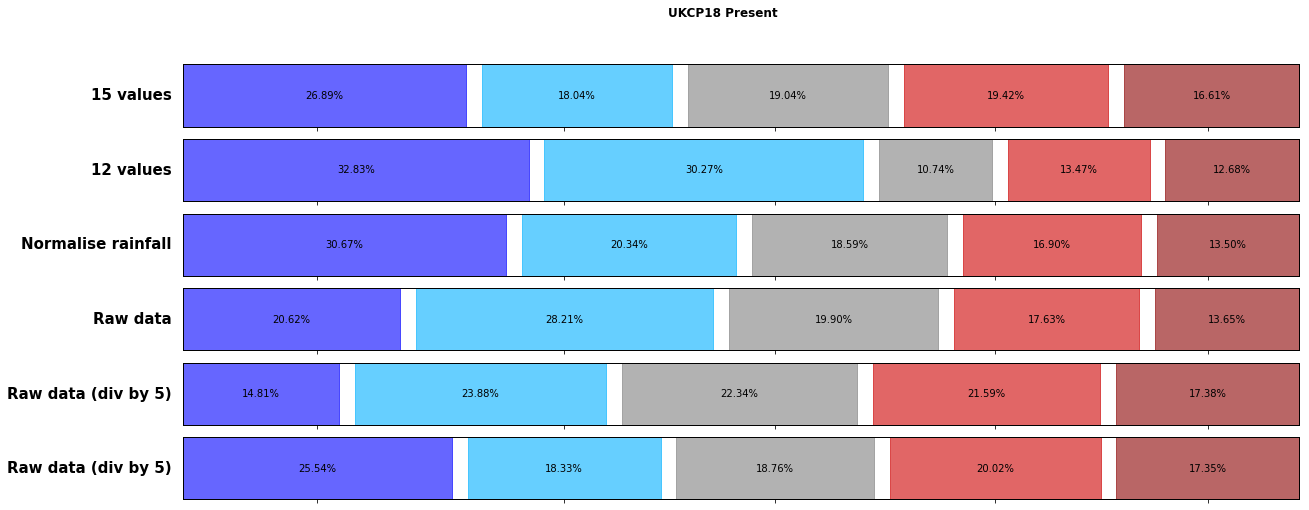

In [32]:
fig, axs = plt.subplots(nrows=6, figsize=(20,8), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], bc005, 'normalized_interpolated_rainfall_15', 'Loading_profile15', quintile_cats, color_mapping, '15 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], bc005, 'normalized_interpolated_rainfall_12', 'Loading_profile12', quintile_cats, color_mapping, '12 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], bc005, 'normalized_rainfall', 'Loading_profile_normalised_rain',quintile_cats, color_mapping, 'Normalise rainfall', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], bc005, 'precip', 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'Raw data', True)
create_single_variable_mosaic_plot_pctlabels(axs[4], bc005_divisibleby5, 'precip', 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'Raw data (div by 5)', True)
create_single_variable_mosaic_plot_pctlabels(axs[5], bc005_divisibleby5, 'normalized_interpolated_rainfall_15', 'Loading_profile15',quintile_cats, color_mapping, 'Raw data (div by 5)', True)
fig.suptitle('UKCP18 Present', fontweight="bold");

In [ ]:
def create_single_variable_mosaic_plot_pctlabels(ax, data, rainfall_variable, split_variable, order, color_mapping, title, filter_events=True):
    if filter_events == True:
         data= data[data[rainfall_variable].notnull()]
    # Count the occurrences and reshape for mosaic plot
    count_data = data[split_variable].value_counts().reindex(order, fill_value=0)
    
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    fig, rects = mosaic(mosaic_data, title='', properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.2f}%'
        #print(counter)
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in [0,6,12,18,24]:
                text.set_text(label)
                text.set_fontsize(10)
                text.set_color('black')
#                 text.set_weight('bold')
            counter=counter+1
            
        #print(f'Key: {key}, count {count} Percentage: {percentage:.2f}%, Label: {label}, x1: {x1}, x2: {x2}, y1: {y1}, y2: {y2}')

    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')      

In [ ]:
    df['Loading_profile12_new'] = df['max_quintile_profile_12_new'].map(quintile_mapping)
    df['Loading_profile15_new'] = df['max_quintile_profile_15_new'].map(quintile_mapping)
    df['Loading_profile_normalised_rain_new'] = df['max_quintile_normalised_rain_new'].map(quintile_mapping)
    df['Loading_profile_raw_rain_new'] = df['max_quintile_raw_rain_new'].map(quintile_mapping)

,gauge_num,season,precip,Volume,Year,duration,normalized_rainfall,normalized_interpolated_rainfall_12,normalized_interpolated_rainfall_15,max_quintile_profile_12,...,interpolated15_incremental_normalised_rainfall,interpolated12_incremental_normalised_rainfall,max_quintile_profile_12_new,max_quintile_profile_15_new,max_quintile_normalised_rain_new,max_quintile_raw_rain_new,Loading_profile12_new,Loading_profile15_new,Loading_profile_normalised_rain_new,Loading_profile_raw_rain_new
0,639,Summer,"[11.994045, 40.25198, 0.01859426]",52.264619,2013,1.5,"[0.2294868913199847, 0.9996442285380958, 1.0]","[0.2294868913199847, 0.3578464475230032, 0.486...","[0.2294868913199847, 0.3321745362823995, 0.434...",1,...,"[0.2294868913199847, 0.14280631836258514, 0.14...","[0.2294868913199847, 0.18175349609783562, 0.18...",1.0,1.0,3.0,2,F2,F2,C,F1
1,278,Summer,"[0.41022554, 38.416122, 19.107136]",57.933484,2018,1.5,"[0.007080974851387299, 0.6701883810109998, 1.0]","[0.007080974851387299, 0.11759887587798938, 0....","[0.007080974851387299, 0.09549529567266897, 0....",1,...,"[0.007080974851387299, 0.09574119728728567, 0....","[0.007080974851387299, 0.12185243291109087, 0....",2.0,4.0,3.0,2,F1,B1,C,F1
2,1187,Summer,"[31.662083, 41.125057, 0.09683927]",72.883979,2004,1.5,"[0.43441759515774037, 0.9986713229578031, 1.0]","[0.43441759515774037, 0.5284598831244175, 0.62...","[0.43441759515774037, 0.5096514255310821, 0.58...",1,...,"[0.43441759515774037, 0.1426673318511147, 0.14...","[0.43441759515774037, 0.181576604174146, 0.181...",1.0,1.0,3.0,2,F2,F2,C,F1
3,278,Summer,"[12.959543, 67.56148, 0.8737793]",81.394802,2007,1.5,"[0.15921831165870404, 0.9892649250896947, 1.0]","[0.15921831165870404, 0.2975594138972025, 0.43...","[0.15921831165870404, 0.2698911934495028, 0.38...",1,...,"[0.15921831165870404, 0.14132356072709928, 0.1...","[0.15921831165870404, 0.17986635001630813, 0.1...",2.0,1.0,3.0,2,F1,F2,C,F1
4,278,Winter,"[5.0961423, 17.838715, 1.0701468]",24.005004,2006,1.5,"[0.21229499810833194, 0.9554198451480372, 1.0]","[0.21229499810833194, 0.33614913928161616, 0.4...","[0.21229499810833194, 0.3113783110469593, 0.41...",2,...,"[0.21229499810833194, 0.1364885493068624, 0.13...","[0.21229499810833194, 0.17371269911782497, 0.1...",1.0,1.0,3.0,2,F2,F2,C,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125248,1292,None,"[16.59639, 3.8083603]",20.404750,2019,NaN,None,None,None,None,...,None,None,NaN,NaN,NaN,1,NaN,NaN,NaN,F2
125249,1292,None,"[13.888785, 13.173254]",27.062039,2015,NaN,None,None,None,None,...,None,None,NaN,NaN,NaN,1,NaN,NaN,NaN,F2
125250,1292,None,[0.5277154],0.527715,2003,NaN,None,None,None,None,...,None,None,NaN,NaN,NaN,1,NaN,NaN,NaN,F2
125251,1292,None,"[4.0384545, 2.8973074]",6.935762,2011,NaN,None,None,None,None,...,None,None,NaN,NaN,NaN,1,NaN,NaN,NaN,F2


In [48]:
data=bc005
data= data[data['interpolated15_cumulative_normalised_rainfall'].notnull()]
# Count the occurrences and reshape for mosaic plot
count_data = data['max_quintile_profile_15_new'].value_counts()#.reindex(quintile_cats, fill_value=0)
count_data
# # Convert to dictionary format suitable for mosaic plot
# mosaic_data = count_data.to_dict()


5.0    112535
1.0      4538
4.0      2228
Name: max_quintile_profile_15_new, dtype: int64

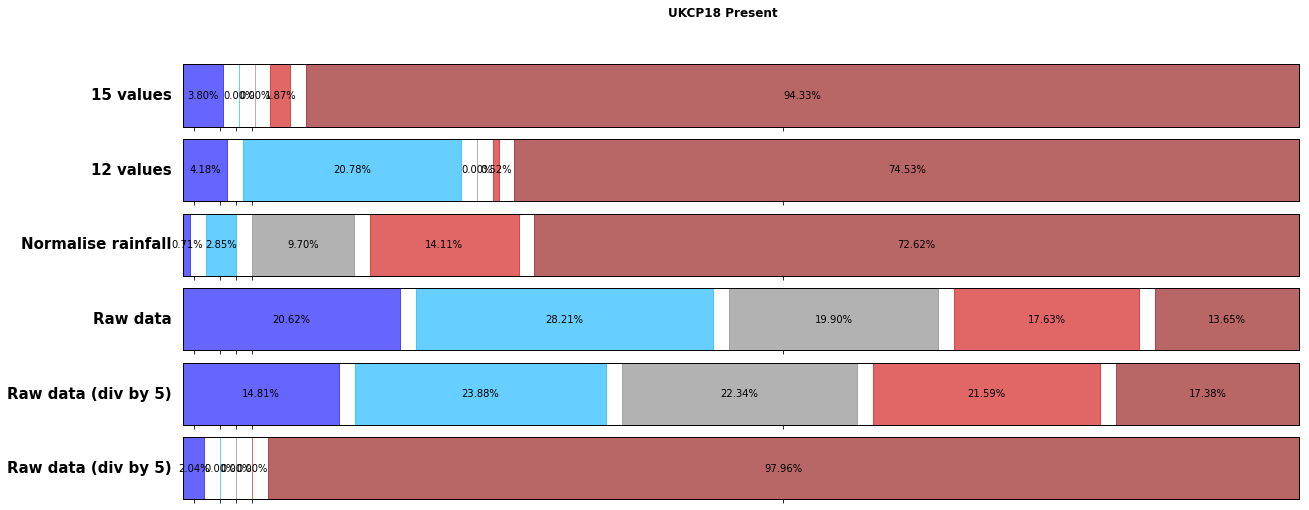

In [37]:
fig, axs = plt.subplots(nrows=6, figsize=(20,8), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], bc005, 'interpolated15_cumulative_normalised_rainfall', 'Loading_profile15_new', quintile_cats, color_mapping, '15 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], bc005, 'interpolated12_cumulative_normalised_rainfall', 'Loading_profile12_new', quintile_cats, color_mapping, '12 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], bc005, 'normalized_rainfall_new', 'Loading_profile_normalised_rain_new',quintile_cats, color_mapping, 'Normalise rainfall', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], bc005, 'precip', 'Loading_profile_raw_rain_new',quintile_cats, color_mapping, 'Raw data', True)
create_single_variable_mosaic_plot_pctlabels(axs[4], bc005_divisibleby5, 'precip', 'Loading_profile_raw_rain_new',quintile_cats, color_mapping, 'Raw data (div by 5)', True)
create_single_variable_mosaic_plot_pctlabels(axs[5], bc005_divisibleby5, 'interpolated15_cumulative_normalised_rainfall', 'Loading_profile15_new',quintile_cats, color_mapping, 'Raw data (div by 5)', True)
fig.suptitle('UKCP18 Present', fontweight="bold");

In [ ]:
fig, axs = plt.subplots(nrows=6, figsize=(20,8), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], ukcp18_present, 'normalized_interpolated_rainfall_15', 'Loading_profile15', quintile_cats, color_mapping, '15 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], ukcp18_present, 'normalized_interpolated_rainfall_12', 'Loading_profile12', quintile_cats, color_mapping, '12 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], ukcp18_present, 'normalized_rainfall', 'Loading_profile_normalised_rain',quintile_cats, color_mapping, 'Normalise rainfall', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], ukcp18_present, 'precip', 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'Raw data', True)
create_single_variable_mosaic_plot_pctlabels(axs[4], ukcp18_present_divisibleby5, 'precip', 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'Raw data (div by 5)', True)
create_single_variable_mosaic_plot_pctlabels(axs[5], ukcp18_present_divisibleby5, 'normalized_interpolated_rainfall_15', 'Loading_profile15',quintile_cats, color_mapping, 'Raw data (div by 5)', True)
fig.suptitle('UKCP18 Present', fontweight="bold");

NameError: name 'bb198' is not defined

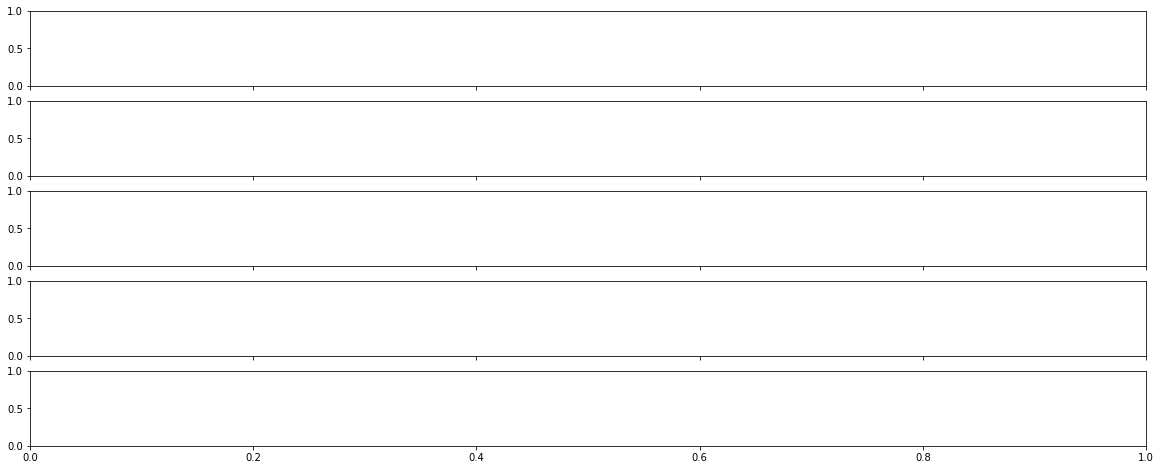

In [84]:
fig, axs = plt.subplots(nrows=5, figsize=(20,8), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], bb198, 'normalized_interpolated_rainfall_15', 'Loading_profile15', quintile_cats, color_mapping, '15 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], bb198, 'normalized_interpolated_rainfall_12', 'Loading_profile12', quintile_cats, color_mapping, '12 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], bb198, 'normalized_rainfall', 'Loading_profile_normalised_rain',quintile_cats, color_mapping, 'Normalise rainfall', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], bb198, 'precip', 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'Raw data', True)
create_single_variable_mosaic_plot_pctlabels(axs[4], bb198_divisibleby5, 'precip', 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'Raw data (div by 5)', True)
fig.suptitle('UKCP18 Future', fontweight="bold");

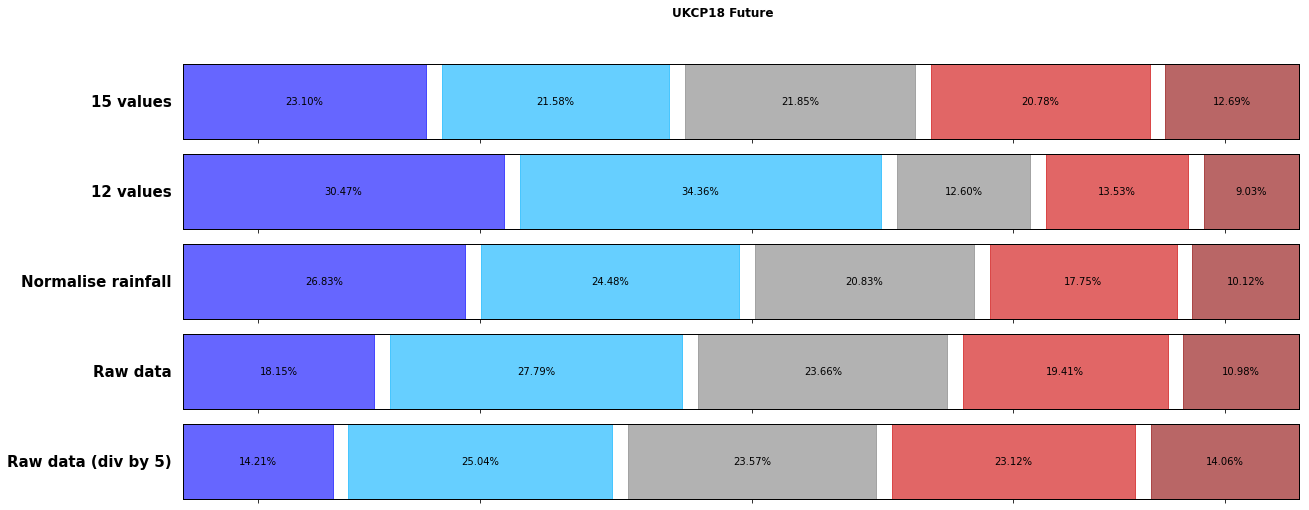

In [83]:
fig, axs = plt.subplots(nrows=5, figsize=(20,8), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod, 'normalized_interpolated_rainfall_15', 'Loading_profile15', quintile_cats, color_mapping, '15 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], nimrod, 'normalized_interpolated_rainfall_12', 'Loading_profile12', quintile_cats, color_mapping, '12 values', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], nimrod, 'normalized_rainfall', 'Loading_profile_normalised_rain',quintile_cats, color_mapping, 'Normalise rainfall', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], nimrod, 'precip', 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'Raw data', True)
create_single_variable_mosaic_plot_pctlabels(axs[4], nimrod_divisibleby5, 'precip', 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'Raw data (div by 5)', True)
fig.suptitle('NIMROD', fontweight="bold");

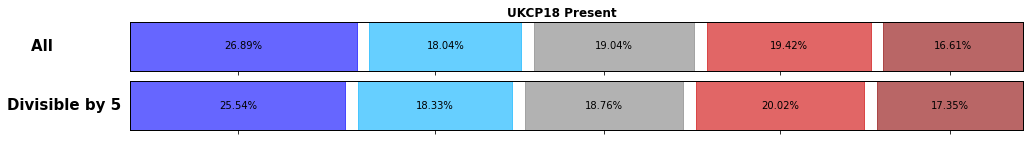

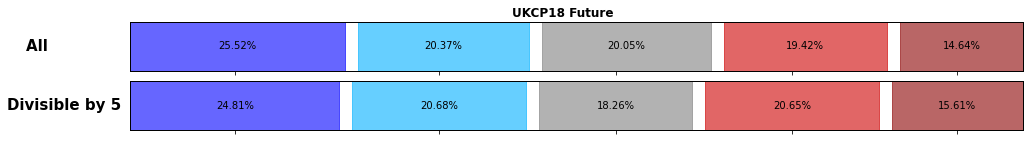

In [47]:
# Desired order of loading categories
# fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True) 
# create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod, 'Loading', quintile_cats,color_mapping, 'All             ', True)
# create_single_variable_mosaic_plot_pctlabels(axs[1], nimrod_divisibleby5, 'Loading', quintile_cats,color_mapping, 'Divisible by 5', True)
# fig.suptitle('NIMROD', fontweight="bold");

fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], ukcp18_present, 'normalized_interpolated_rainfall_15', 'Loading_profile15', quintile_cats, color_mapping, 'All             ', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], ukcp18_present_divisibleby5, 'normalized_interpolated_rainfall_15', 'Loading_profile15',quintile_cats, color_mapping, 'Divisible by 5', True)
fig.suptitle('UKCP18 Present', fontweight="bold");

# Desired order of loading categories
fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], ukcp18_future, 'normalized_interpolated_rainfall_15', 'Loading_profile15', quintile_cats,color_mapping, 'All              ', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], ukcp18_future_divisibleby5,  'normalized_interpolated_rainfall_15', 'Loading_profile15',quintile_cats,color_mapping, 'Divisible by 5', True)
fig.suptitle('UKCP18 Future', fontweight="bold");

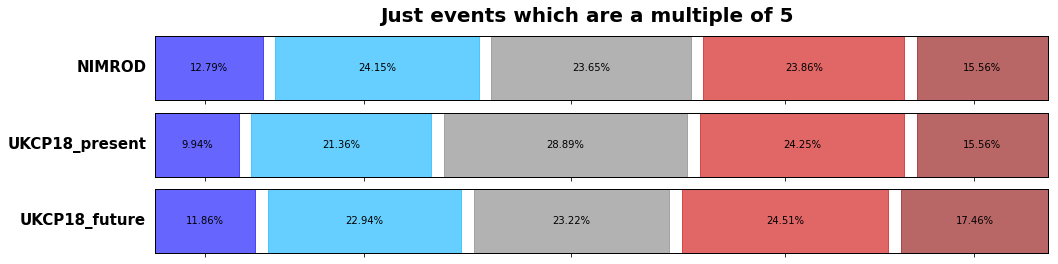

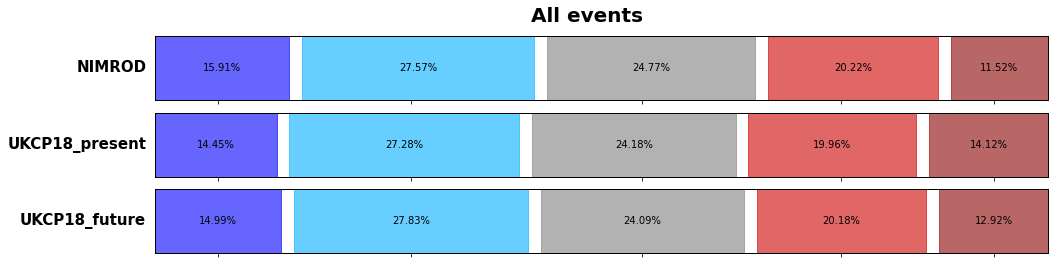

In [239]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =3, figsize=(16,4), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod_divisibleby5, 'Loading', quintile_cats,color_mapping, 'NIMROD', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], ukcp18_present_divisibleby5, 'Loading', quintile_cats, color_mapping, 'UKCP18_present', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], ukcp18_future_divisibleby5, 'Loading', quintile_cats,color_mapping, 'UKCP18_future', True)
fig.suptitle('Just events which are a multiple of 5', fontweight="bold", fontsize=20);

# # Desired order of loading categories
fig, axs = plt.subplots(nrows =3, figsize=(16,4), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod, 'Loading', quintile_cats,color_mapping, 'NIMROD', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], ukcp18_present, 'Loading', quintile_cats, color_mapping, 'UKCP18_present', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], ukcp18_future, 'Loading', quintile_cats,color_mapping, 'UKCP18_future', True)
fig.suptitle('All events', fontweight="bold", fontsize=20);

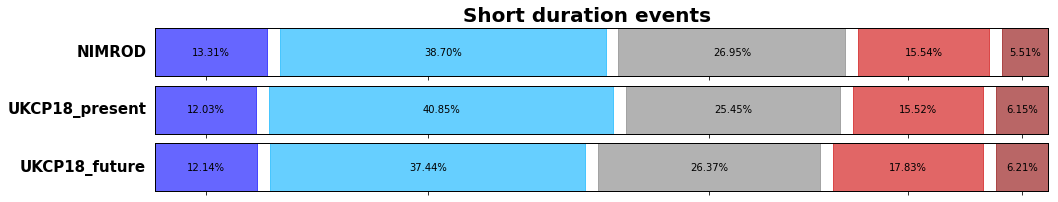

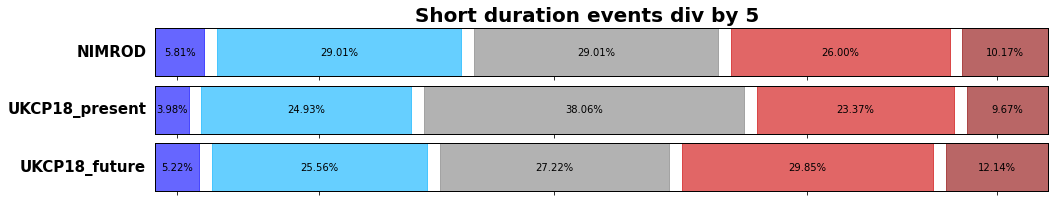

In [251]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =3, figsize=(16,3), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod_shortdurations, 'Loading', quintile_cats,color_mapping, 'NIMROD', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], ukcp18_present_shortdurations, 'Loading', quintile_cats, color_mapping, 'UKCP18_present', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], ukcp18_future_shortdurations, 'Loading', quintile_cats,color_mapping, 'UKCP18_future', True)
fig.suptitle('Short duration events', fontweight="bold", fontsize=20);

# Desired order of loading categories
fig, axs = plt.subplots(nrows =3, figsize=(16,3), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod_shortdurations_divisibleby5, 'Loading', quintile_cats,color_mapping, 'NIMROD', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], ukcp18_present_shortdurations_divisibleby5, 'Loading', quintile_cats, color_mapping, 'UKCP18_present', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], ukcp18_future_shortdurations_divisibleby5, 'Loading', quintile_cats,color_mapping, 'UKCP18_future', True)
fig.suptitle('Short duration events div by 5', fontweight="bold", fontsize=20);

In [84]:
# color_mapping = {
#     'F': (0.0, 0.0, 1.0, 0.6),    # darkblue with 0.6 alpha
#     'C': (0.5, 0.5, 0.5, 0.6),     # grey with 0.6 alpha
#     'B': (0.5451, 0.0, 0.0, 0.6)}  # darkred with 0.6 alpha

# color_mapping_seasons = {
#     'Summer': (1.0, 0.6471, 0.0, 0.6), # orange with 0.6 alpha
#     'Winter': (0.0, 0.0, 1.0, 0.6)}     # blue with 0.6 alpha}

# quintile_mapping = {1: 'F', 2: 'C', 3: 'B'}
# quintile_cats = ['F', 'C', 'B']
# n= 3
# quintile_cats_season = ['Summer', 'Winter']    

In [66]:
# proportions = categorize_rainfall_events_five(nimrod['precipitation (mm/hr)'])
# print(f"NIMROD (present): {proportions}")
# proportions = categorize_rainfall_events_five(ukcp18_present['precipitation (mm/hr)'])
# print(f"UKCP18 (present): {proportions}")
# proportions = categorize_rainfall_events_five(ukcp18_future['precipitation (mm/hr)'])
# print(f"UKCP18 (future): {proportions}")

In [ ]:
def create_single_variable_mosaic_plot_pctlabels_fromprofiles(ax, data, variable, order, color_mapping, title, filter_events=True):
    # Count the occurrences and reshape for mosaic plot
    count_data = data[variable].value_counts().reindex(order, fill_value=0)
    
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    fig, rects = mosaic(mosaic_data, title='', properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.2f}%'
        #print(counter)
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in [0,6,12,18,24]:
                text.set_text(label)
                text.set_fontsize(10)
                text.set_color('black')
#                 text.set_weight('bold')
            counter=counter+1
            
        #print(f'Key: {key}, count {count} Percentage: {percentage:.2f}%, Label: {label}, x1: {x1}, x2: {x2}, y1: {y1}, y2: {y2}')

    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')  

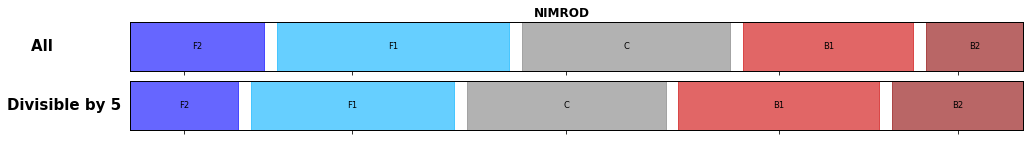

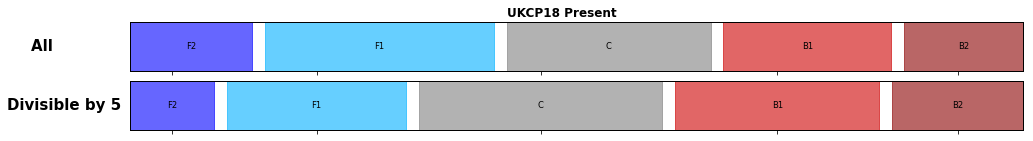

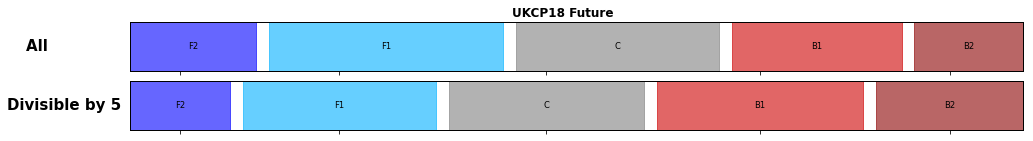

In [254]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True) 
create_single_variable_mosaic_plot(axs[0], nimrod, 'Loading', quintile_cats,color_mapping, 'All             ', True)
create_single_variable_mosaic_plot(axs[1], nimrod_divisibleby5, 'Loading', quintile_cats,color_mapping, 'Divisible by 5', True)
fig.suptitle('NIMROD', fontweight="bold");

fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True)
create_single_variable_mosaic_plot(axs[0], ukcp18_present, 'Loading', quintile_cats, color_mapping, 'All             ', True)
create_single_variable_mosaic_plot(axs[1], ukcp18_present_divisibleby5, 'Loading', quintile_cats, color_mapping, 'Divisible by 5', True)
fig.suptitle('UKCP18 Present', fontweight="bold");

# Desired order of loading categories
fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True)
create_single_variable_mosaic_plot(axs[0], ukcp18_future, 'Loading', quintile_cats,color_mapping, 'All              ', True)
create_single_variable_mosaic_plot(axs[1], ukcp18_future_divisibleby5, 'Loading', quintile_cats,color_mapping, 'Divisible by 5', True)
fig.suptitle('UKCP18 Future', fontweight="bold");

In [326]:
# 1. Calculate unique values and their counts for both datasets
unique_present, counts_present = np.unique(all_events['Loading'], return_counts=True)
unique_divisibleby5, counts_divisibleby5 = np.unique(div_by_5['Loading'], return_counts=True)

# 2. Calculate the total count of values in each dataset
total_present = len(all_events)
total_divisibleby5 = len(div_by_5)

# 3. Calculate the percentages
percent_present = (counts_present / total_present) * 100
percent_divisibleby5 = (counts_divisibleby5 / total_divisibleby5) * 100

# Print the results
print("ukcp18_present unique values and their percentages:")
for value, count, percent in zip(unique_present, counts_present, percent_present):
    print(f"Value: {value}, Count: {count}, Percentage: {percent:.2f}%")

print("\nukcp18_present_divisibleby5 unique values and their percentages:")
for value, count, percent in zip(unique_divisibleby5, counts_divisibleby5, percent_divisibleby5):
    print(f"Value: {value}, Count: {count}, Percentage: {percent:.2f}%")

ukcp18_present unique values and their percentages:
Value: B1, Count: 21182, Percentage: 18.45%
Value: B2, Count: 14381, Percentage: 12.53%
Value: C, Count: 25255, Percentage: 22.00%
Value: F1, Count: 32107, Percentage: 27.97%
Value: F2, Count: 21852, Percentage: 19.04%

ukcp18_present_divisibleby5 unique values and their percentages:
Value: B1, Count: 5040, Percentage: 22.36%
Value: B2, Count: 3527, Percentage: 15.65%
Value: C, Count: 4996, Percentage: 22.17%
Value: F1, Count: 5543, Percentage: 24.60%
Value: F2, Count: 3430, Percentage: 15.22%


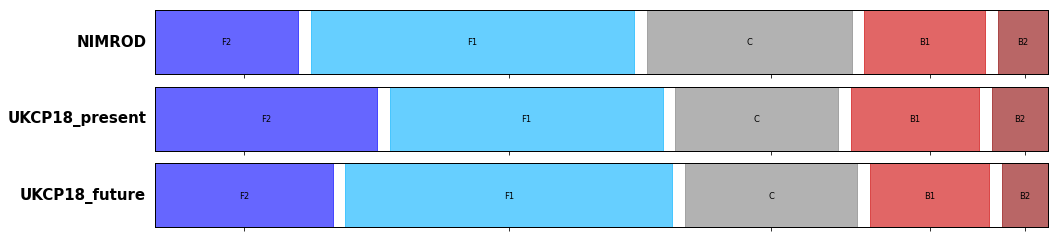

In [95]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =3, figsize=(16,4), sharex=True)
create_single_variable_mosaic_plot(axs[0], nimrod_shortdurations, 'Loading', quintile_cats,color_mapping, 'NIMROD')
create_single_variable_mosaic_plot(axs[1], ukcp18_present_shortdurations, 'Loading', quintile_cats, color_mapping, 'UKCP18_present')
create_single_variable_mosaic_plot(axs[2], ukcp18_future_shortdurations, 'Loading', quintile_cats, color_mapping, 'UKCP18_future')

In [ ]:
### Is there maybe more data in summer for UKCP18? (ie less data in summer for NIMROD?)
# How could I check?

In [ ]:
def calculate_center_of_mass(rainfall_event):
    total_rainfall = np.sum(rainfall_event)
    time_steps = np.arange(len(rainfall_event))
    center_of_mass = np.sum(time_steps * rainfall_event) / total_rainfall
    return center_of_mass

## Compare proportion of events in each loading category (split by duration)

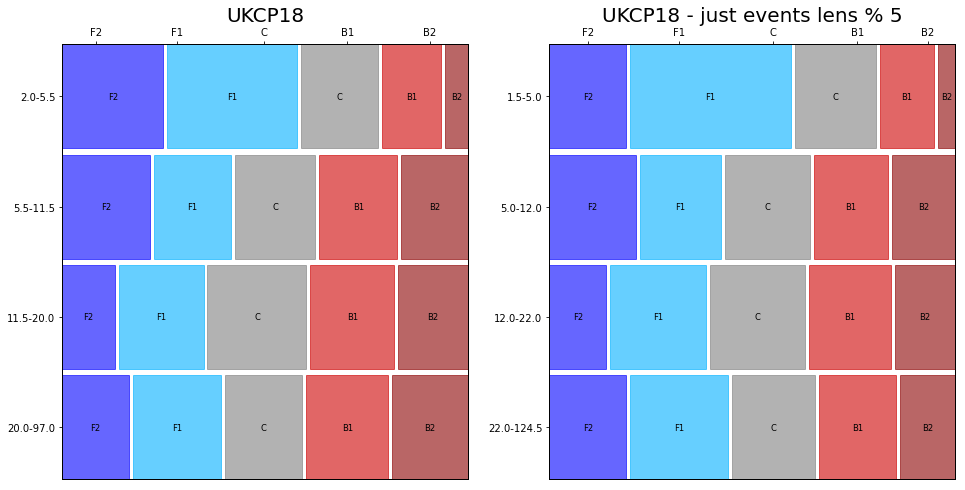

In [260]:
fig, axs = plt.subplots(ncols =2, figsize=(16,8))
create_mosaic_plot(axs[0],ukcp18_present , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading', include_all= False)
axs[0].set_title('UKCP18', fontsize=20)
create_mosaic_plot(axs[1],ukcp18_future, cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading', include_all= False)
axs[1].set_title('UKCP18 - just events lens % 5', fontsize=20);

# Mosaic plots - split by season

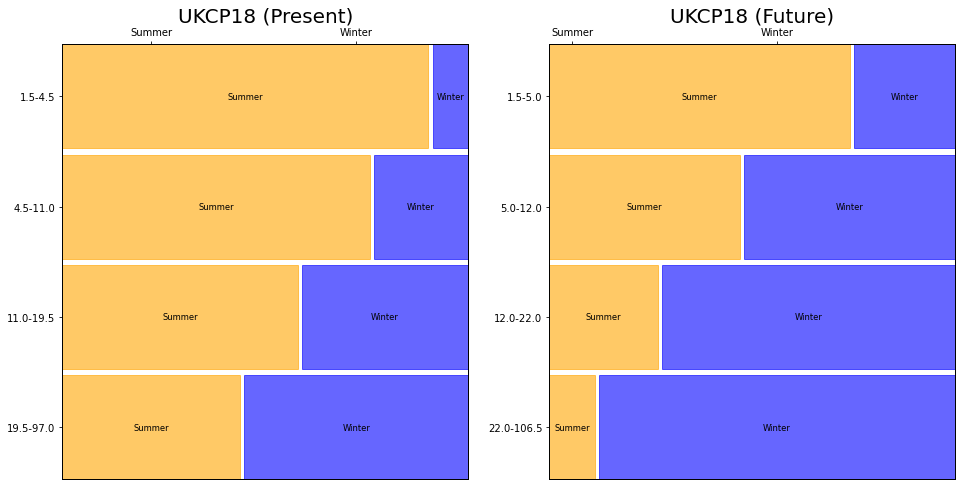

In [68]:
fig, axs = plt.subplots(ncols =2, figsize=(16,8))
create_mosaic_plot(axs[0],ukcp18_present , cross_variable1 = 'DurationRange_personalised', cross_variable2='Season', include_all= False)
axs[0].set_title('UKCP18 (Present)', fontsize=20)
create_mosaic_plot(axs[1],ukcp18_future, cross_variable1 = 'DurationRange_personalised', cross_variable2='Season', include_all= False)
axs[1].set_title('UKCP18 (Future)', fontsize=20);

# Plot profiles clouds

In [268]:
plot_profiles_by_percentile(ukcp18_future, percent_10=95, percent_1=99)

NameError: name 'plot_profiles_by_percentile' is not defined

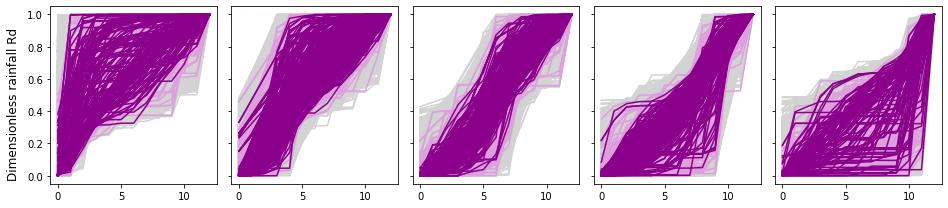

In [263]:
plot_profiles_by_percentile(ukcp18_present, percent_10=95, percent_1=99)

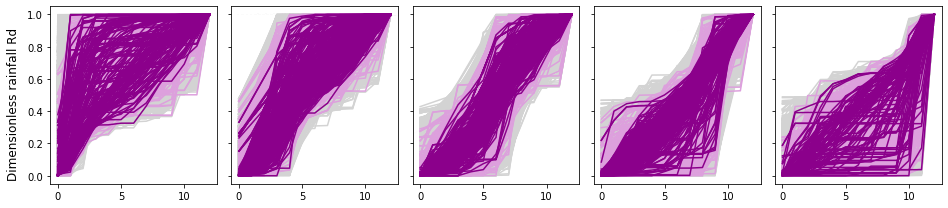

In [85]:
plot_profiles_by_percentile(ukcp18_present_divisibley5, percent_10=90, percent_1=99)

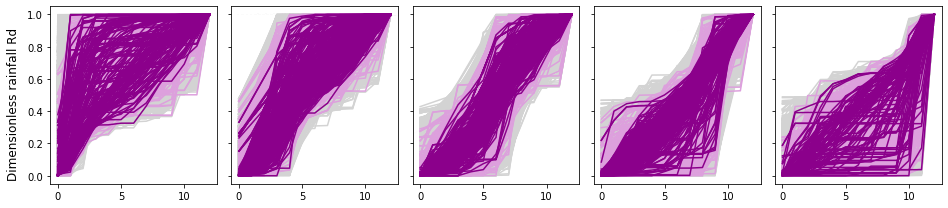

In [71]:
plot_profiles_by_percentile(nimrod, percent_10=90, percent_1=99)

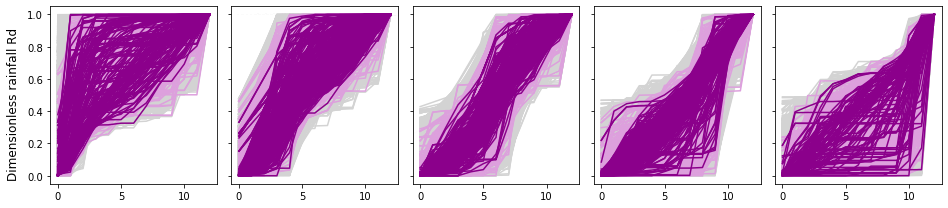

In [83]:
plot_profiles_by_percentile(nimrod_divisibley5, percent_10=90, percent_1=99)

### Plot profiles

In [280]:
# ukcp18_present_interpolated_profiles = create_interpolated_profiles(ukcp18_present_divisibley5)
# # ukcp18_present_centroids = create_kmeans_centroids(ukcp18_interpolated_profiles, 5)

# nimrod_interpolated_profiles = create_interpolated_profiles(nimrod_divisibley5)
# nimrod_centroids = create_kmeans_centroids(nimrod_interpolated_profiles, 5)

ukcp18_future_interpolated_profiles = create_interpolated_profiles(ukcp18_future)
# ukcp18_future_centroids = create_kmeans_centroids(ukcp18_fututre_profiles, 5)

In [284]:
# test = ukcp18_future
# test['Profile_len15'] = ukcp18_future_interpolated_profiles
test.loc[test['Profile'].isna(), 'Profile_len15'] = None

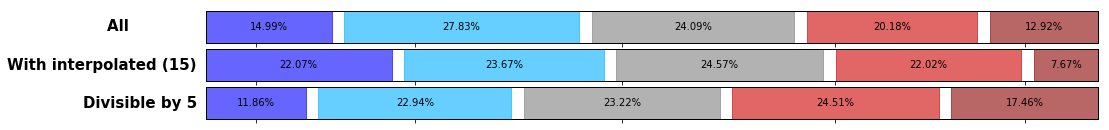

In [304]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =3, figsize=(16,2), sharex=True) 
create_single_variable_mosaic_plot_pctlabels(axs[0], ukcp18_future, 'Loading', quintile_cats,color_mapping, 'All             ', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], test, 'Loading_profile15', quintile_cats,color_mapping, 'With interpolated (15)', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], ukcp18_future_divisibleby5, 'Loading', quintile_cats,color_mapping, 'Divisible by 5', True)


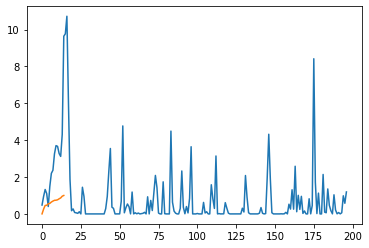

In [298]:
test['max_quintile_profile15'] = test['Profile_len15'].apply(lambda x: find_fifth_with_most_rain_using_cumulative_rainfall(x) if x is not None else None)

# # Add the loadings
test['Loading_profile15'] = test['max_quintile_profile15'].map(quintile_mapping)


In [ ]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True) 
create_single_variable_mosaic_plot(axs[0], nimrod, 'Loading', quintile_cats,color_mapping, 'All             ', True)
create_single_variable_mosaic_plot(axs[1], nimrod_divisibleby5, 'Loading', quintile_cats,color_mapping, 'Divisible by 5', True)
fig.suptitle('NIMROD', fontweight="bold");

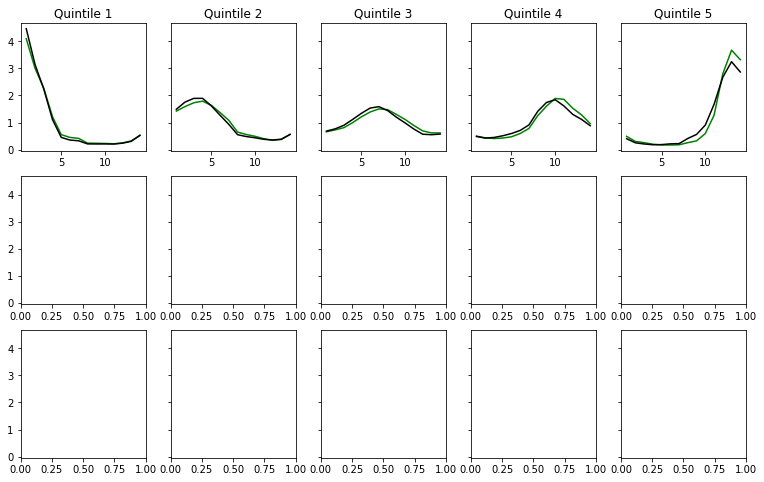

In [274]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(13, 8), sharey=True)

ukcp18_present_centroids_5clusters = create_kmeans_centroids(ukcp18_interpolated_profiles, 5)
ukcp18_future_centroids_5clusters = create_kmeans_centroids(ukcp18_future_interpolated_profiles, 5)
# nimrod_centroids_5clusters = create_kmeans_centroids(nimrod_interpolated_profiles, 5)

plot_centroids(axs,0, ukcp18_present_centroids_5clusters, 'green')
plot_centroids(axs,0, ukcp18_future_centroids_5clusters, 'black')
# plot_centroids(axs,0, nimrod_centroids_5clusters, 'black')


# plot_centroids(axs,1, ukcp18_centroids_15clusters, 'blue')
# plot_centroids(axs,1, nimrod_centroids_15clusters, 'black')

# # ukcp18_centroids_15clusters = create_kmeans_centroids(ukcp18_interpolated_profiles, 15)
# # nimrod_centroids_15clusters = create_kmeans_centroids(nimrod_interpolated_profiles, 15)

# plot_centroids(axs,2, ukcp18_centroids_15clusters, 'blue')
# plot_centroids(axs,2, nimrod_centroids_15clusters, 'black')

### Contingency tables

In [ ]:
def create_absolute_contingency_table(data, column):
    # Create a contingency table with absolute counts
    contingency_table = pd.crosstab(data[column], data['Loading'])

    # Calculate the overall sum for each loading category
    overall_counts = contingency_table.sum(axis=0)  # Sum across all duration categories

    # Add the 'All' row with the overall counts
    contingency_table.loc['All'] = overall_counts

    # Convert the absolute contingency table to a list of lists for tabulate
    table_data = contingency_table.reset_index().values.tolist()
    headers = [column] + list(contingency_table.columns)

    # Print the formatted table using tabulate
    print("Absolute Contingency Table with 'All' Row:")
    print(tabulate(table_data, headers=headers, tablefmt='pretty'))    

In [211]:
create_absolute_contingency_table(ukcp18_present_divisibleby5, "DurationRange_personalised")

Absolute Contingency Table with 'All' Row:
+----------------------------+------+------+------+------+------+
| DurationRange_personalised |  F2  |  F1  |  C   |  B1  |  B2  |
+----------------------------+------+------+------+------+------+
|          2.0-5.5           | 1122 | 2529 | 1507 | 1400 | 753  |
|          5.5-11.5          | 740  | 674  | 823  | 949  | 870  |
|         11.5-20.0          | 715  | 1261 | 1839 | 1527 | 1317 |
|         20.0-97.0          | 824  | 1056 | 985  | 1124 | 1146 |
|            All             | 3401 | 5520 | 5154 | 5000 | 4086 |
+----------------------------+------+------+------+------+------+


In [213]:
create_absolute_contingency_table(ukcp18_present, "DurationRange_personalised")

Absolute Contingency Table with 'All' Row:
+----------------------------+-------+-------+-------+-------+-------+
| DurationRange_personalised |  F2   |  F1   |   C   |  B1   |  B2   |
+----------------------------+-------+-------+-------+-------+-------+
|          2.0-5.5           | 7174  | 9282  | 5444  | 4191  | 1676  |
|          5.5-11.5          | 6211  | 5489  | 5747  | 5558  | 4761  |
|         11.5-20.0          | 3734  | 6039  | 7044  | 5959  | 4990  |
|         20.0-97.0          | 4738  | 6294  | 5502  | 5817  | 5415  |
|            All             | 21857 | 27104 | 23737 | 21525 | 16842 |
+----------------------------+-------+-------+-------+-------+-------+


In [214]:
create_contingency_table(ukcp18_present, "DurationRange_personalised")

Proportional Contingency Table with 'All' Row:
+------------------+------+------+------+------+------+
| DurationCategory |  F2  |  F1  |  C   |  B1  |  B2  |
+------------------+------+------+------+------+------+
|     2.0-5.5      | 25.8 | 33.4 | 19.6 | 15.1 | 6.0  |
|     5.5-11.5     | 22.4 | 19.8 | 20.7 | 20.0 | 17.1 |
|    11.5-20.0     | 13.4 | 21.7 | 25.4 | 21.5 | 18.0 |
|    20.0-97.0     | 17.1 | 22.7 | 19.8 | 21.0 | 19.5 |
|       All        | 19.7 | 24.4 | 21.4 | 19.4 | 15.2 |
+------------------+------+------+------+------+------+


In [212]:
create_contingency_table(ukcp18_present_divisibleby5, "DurationRange_personalised")

Proportional Contingency Table with 'All' Row:
+------------------+------+------+------+------+------+
| DurationCategory |  F2  |  F1  |  C   |  B1  |  B2  |
+------------------+------+------+------+------+------+
|     2.0-5.5      | 15.3 | 34.6 | 20.6 | 19.1 | 10.3 |
|     5.5-11.5     | 18.2 | 16.6 | 20.3 | 23.4 | 21.4 |
|    11.5-20.0     | 10.7 | 18.9 | 27.6 | 22.9 | 19.8 |
|    20.0-97.0     | 16.0 | 20.6 | 19.2 | 21.9 | 22.3 |
|       All        | 14.7 | 23.8 | 22.3 | 21.6 | 17.6 |
+------------------+------+------+------+------+------+
